In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class FWIForward(nn.Module):
    '''Forward modeling

    Args:
        ctx: dictionary that contains parameters for forward modeling, see FWM() for details 
        device: torch device
        sample_temporal: timestep interval
        sample_spatial: percentage of # of receivers
        normalize: whether denormalize velocity map and return normalized seismic data
        v_denorm_func: denormalization function for velocity map
        s_norm_func: normalization function for seismic data
    '''
    def __init__(self, ctx, device, sample_temporal=1, sample_spatial=1.0, normalize=True, v_denorm_func=None, s_norm_func=None):
        super(FWIForward, self).__init__()
        self.device = device
        self.normalize = normalize
        if normalize:
            self.v_denorm_func = v_denorm_func
            self.s_norm_func = s_norm_func
        self.sample_temporal = sample_temporal
        # Compute the locations of sources and receivers
        if 'sx' not in ctx.keys():
            ctx['sx'] = np.linspace(0, ctx['n_grid'] - 1, num=ctx['ns']) * ctx['dx']
        else:
            ctx['sx'] = np.array(ctx['sx']) * ctx['dx']
        if 'gx' not in ctx.keys():
            ctx['gx'] = np.linspace(0, ctx['n_grid'] - 1, num=int(sample_spatial * ctx['ng'])) * ctx['dx']
        else:
            ctx['gx'] = np.array(ctx['gx']) * ctx['dx']
        self.ctx = ctx

    # Source func
    def ricker(self, f, dt, nt):
        nw = 2.2/f/dt
        nw = 2*np.floor(nw/2)+1
        nc = np.floor(nw/2)
        k = np.arange(nw)
        
        alpha = (nc-k)*f*dt*np.pi
        beta = alpha ** 2
        w0 = (1-beta*2)*np.exp(-beta)
        w = np.zeros(nt)
        w[:len(w0)] = w0
        return w

    # Absorbing boundary condition
    # UPFWI paper Equation 16
    # Collino & Tsogka (2001) paper Equation 20&21
    def get_Abc(self, vp, nbc, dx):
        dimrange = 1.0*torch.unsqueeze(torch.arange(nbc, device=self.device), dim=-1)
        damp = torch.zeros_like(vp, device=self.device, requires_grad=False) 
        
        velmin,_ = torch.min(vp.view(vp.shape[0],-1), dim=-1, keepdim=False)

        a = (nbc-1)*dx       
        kappa = 3.0 * velmin * np.log(1e7) / (2.0 * a)
        kappa = torch.unsqueeze(kappa,dim=0)
        kappa = torch.repeat_interleave(kappa, nbc, dim=0)
        
        damp1d = kappa * (dimrange*dx/a) ** 2
        damp1d = damp1d.permute(1,0).unsqueeze(1)
        
        damp[:,:,:nbc, :] = torch.repeat_interleave(torch.flip(damp1d,dims=[-1]).unsqueeze(-1), vp.shape[-1], dim=-1) 
        damp[:,:,-nbc:,:] = torch.repeat_interleave(damp1d.unsqueeze(-1), vp.shape[-1], dim=-1) 
        damp[:,:,:, :nbc] = torch.repeat_interleave(torch.flip(damp1d,dims=[-1]).unsqueeze(-2), vp.shape[-2], dim=-2) 
        damp[:,:,:,-nbc:] = torch.repeat_interleave(damp1d.unsqueeze(-2), vp.shape[-2], dim=-2) 
        return damp

    # Adjust index after adding abc
    def adj_sr(self, sx,sz,gx,gz,dx,nbc):
        isx = np.around(sx/dx)+nbc
        isz = np.around(sz/dx)+nbc
        
        igx = np.around(gx/dx)+nbc
        igz = np.around(gz/dx)+nbc
        return isx.astype('int'),int(isz),igx.astype('int'),int(igz)

    def FWM(self, v, nbc, dx, nt, dt, f, sx, sz, gx, gz, **kwargs):
        ''' Forward modeling
        2nd-rder central FD in time, 4th-order central FD in space

        Args:
            v (tensor): velocity map, (N, 1, Depth, Width)
            nbc (int): # of grids for boundary condition
            dx (int): grid size
            dt (int): time interval
            f (int): source peak frequency
            sx (numpy array): source location 
            sz (int): source depth
            gx (numpy array): receiver location 
            gz (int): receiver depth
        '''
        src = self.ricker(f, dt, nt)
        alpha = (v*dt/dx) ** 2

        abc = self.get_Abc(v, nbc, dx)
        kappa = abc*dt

        c1 = -2.5
        c2 = 4.0/3.0
        c3 = -1.0/12.0 

        temp1 = 2+2*c1*alpha-kappa
        temp2 = 1-kappa
        beta_dt = (v*dt) ** 2
        
        ns = len(sx)
        isx,isz,igx,igz = self.adj_sr(sx,sz,gx,gz,dx,nbc)
        seis = []
        p1 = torch.zeros((v.shape[0], ns, v.shape[2], v.shape[3]), device=self.device, requires_grad=True)
        p0 = torch.zeros((v.shape[0], ns, v.shape[2], v.shape[3]), device=self.device, requires_grad=True)
        p  = torch.zeros((v.shape[0], ns, v.shape[2], v.shape[3]), device=self.device, requires_grad=True)
        for i in range(nt):
            p = (temp1*p1 - temp2*p0 + alpha * 
                (c2*(torch.roll(p1, 1, dims = -2) + torch.roll(p1, -1, dims = -2) + torch.roll(p1, 1, dims = -1)+ torch.roll(p1, -1, dims = -1))
                +c3*(torch.roll(p1, 2, dims = -2) + torch.roll(p1, -2, dims = -2) + torch.roll(p1, 2, dims = -1)+ torch.roll(p1, -2, dims = -1))
                ))
            for loc in range(ns):
                p[:,loc,isz,isx[loc]] = p[:,loc,isz,isx[loc]] + beta_dt[:,0,isz,isx[loc]] * src[i]
            if i % self.sample_temporal == 0:
                seis.append(torch.unsqueeze(p[:, :, [igz]*len(igx), igx], dim=2))
            p0=p1
            p1=p
        return torch.cat(seis, dim=2)


    def forward(self, v):
        if self.normalize:
            v = self.v_denorm_func(v)
        v_pad = F.pad(v, (self.ctx['nbc'],) * 4, mode='replicate')
        s = self.FWM(v_pad, **self.ctx)
        return self.s_norm_func(s) if self.normalize else s


In [5]:
def plot_single(data, index=0, source=0, axis=False, save_path="plots/"):
    data = data[index, source]
    nz, nx = data.shape
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    im = ax.matshow(data, aspect='auto', cmap='gray', vmin=-1, vmax=2)

    # Maintain proportional scaling
    ax.set_aspect(aspect=nx / nz)

    # X-axis: 0 to 700 meters
    num_ticks = 5
    x_ticks = np.linspace(0, nx - 1, num_ticks).astype(int)
    x_labels = np.linspace(0, 700, num_ticks).astype(int)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Length (m)')
    # Y-axis: 0 to 1000 ms (inclusive)
    y_labels = np.arange(0, 1001, 200)
    y_ticks = (y_labels / 1000 * nz).astype(int)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel('Time (ms)')
    if not axis:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path + f"seismic_plot_index_{index}_source_{source}_axis{axis}_10source.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    #plt.show()

In [3]:
import matplotlib.pyplot as plt
from scripts.data_utils import data_trans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
ctx = {
'n_grid': 70, # Number of grid points in one dimension (depth or width)
'nt': 1000, # Reduced number of time steps for simplicity
'dx': 10, # Grid spacing (meters)
'nbc': 120, # Number of boundary condition layers
'dt': 1e-3, # Time interval (seconds)
'f': 15, # Source frequency (Hz)
'sz': 10, # Source depth
'gz': 10, # Receiver depth
'ng': 70, # Number of receivers
'ns': 10#, # Number of sources
#'sx': [10, 15, 20, 34, 52, 69], # Source locations
}
fwi_forward = FWIForward(ctx, device, normalize=False, v_denorm_func=data_trans.v_denormalize, s_norm_func=data_trans.s_normalize_none)

Using device: cuda


In [6]:
vm_sample = np.load(f"dataset/velocity_model/CF.npy")
s_data = fwi_forward(torch.tensor(vm_sample[0:1,:,:,:], dtype=torch.float32, device=device))
s_data_numpy = s_data.cpu().detach().numpy()
for i in range(10):
    plot_single(s_data_numpy, index=0, source=i, axis=False)

In [12]:
import os
os.makedirs("dataset/2C/client1", exist_ok=True)
os.makedirs("dataset/2C/client2", exist_ok=True)

for stylies in ['CF','CV','FF','FV']:
    print(f"Processing style: {stylies}")
    vm_sample = np.load(f"dataset/velocity_model/{stylies}.npy")
    seismic_data_client1 = []
    seismic_data_client2 = []
    for i in range(vm_sample.shape[0]):
        s_data = fwi_forward(torch.tensor(vm_sample[i:i+1,:,:,:], dtype=torch.float32, device=device))
        s_data_numpy = s_data.cpu().detach().numpy()
        seismic_data_client1.append(s_data_numpy[:,0:3,:,:35])
        seismic_data_client2.append(s_data_numpy[:,3:6,:,35:])
    seismic_data_client1 = np.concatenate(seismic_data_client1, axis=0)
    seismic_data_client2 = np.concatenate(seismic_data_client2, axis=0)
    print(f"Seismic data shapes: client1 {seismic_data_client1.shape}, client2 {seismic_data_client2.shape}")
    np.save(f"dataset/2C/client1/{stylies}.npy", seismic_data_client1)
    np.save(f"dataset/2C/client2/{stylies}.npy", seismic_data_client2)

Processing style: CF
Seismic data shapes: client1 (10, 3, 1000, 35), client2 (10, 3, 1000, 35)
Processing style: CV
Seismic data shapes: client1 (10, 3, 1000, 35), client2 (10, 3, 1000, 35)
Processing style: FF
Seismic data shapes: client1 (10, 3, 1000, 35), client2 (10, 3, 1000, 35)
Processing style: FV
Seismic data shapes: client1 (10, 3, 1000, 35), client2 (10, 3, 1000, 35)


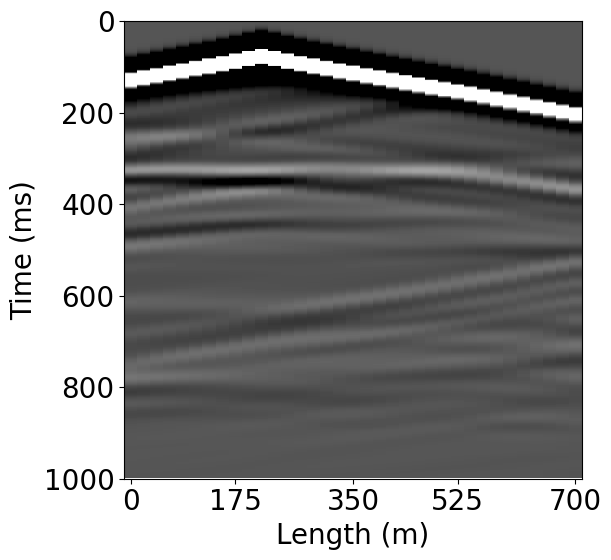

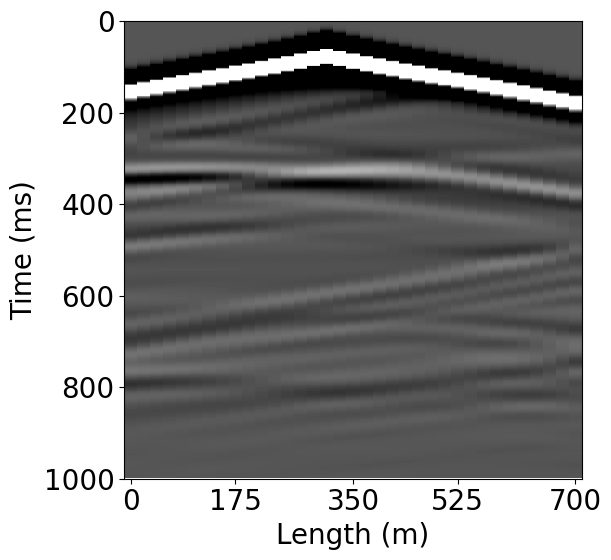

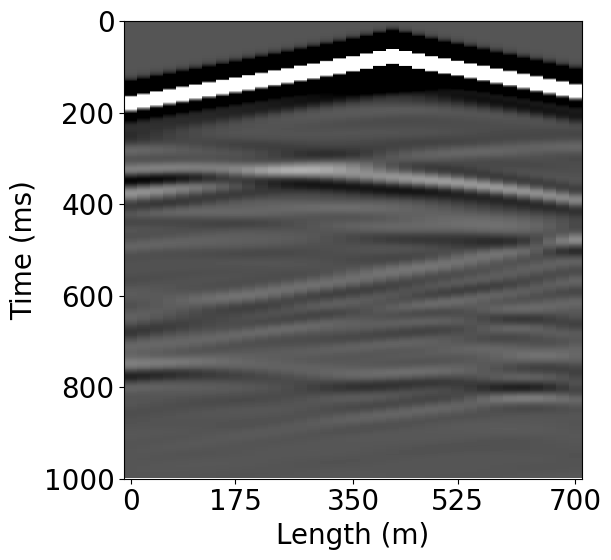

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
sample_seismic_data = np.load("dataset/seismic_data/2C/client1/CF.npy")

for i in range(6):
    plot_single(sample_seismic_data, index=0, source=i, axis=True)


In [15]:
import pickle
with open("experiment_result/FedAvgM_Diffusion_2A_20250805_162757.pkl", "rb") as f:
    fedavgm_results = pickle.load(f)

print(fedavgm_results.keys())

dict_keys(['individual_runs', 'family_histories', 'overall_history'])


In [20]:
print(fedavgm_results['individual_runs'][0])
print(fedavgm_results['family_histories'].keys())
print(fedavgm_results['overall_history'].keys())

{'family': 'CF', 'instance': 0, 'final_model': array([[[[-0.02726158, -0.02733302, -0.02729432, ..., -0.02732542,
          -0.02729784, -0.02731726],
         [-0.02736188, -0.6634958 , -0.6857099 , ..., -0.66644245,
          -0.6163207 , -0.02738617],
         [-0.02733772, -0.6803385 , -0.68294734, ..., -0.67623895,
          -0.67186713, -0.02751544],
         ...,
         [-0.02718201,  0.6328926 ,  0.6604286 , ...,  0.2445367 ,
           0.24499063, -0.02729141],
         [-0.02733388,  0.62909436,  0.60637504, ...,  0.24638006,
           0.23473549, -0.02729303],
         [-0.02724337, -0.02732372, -0.02731576, ..., -0.02730076,
          -0.0272219 , -0.02705737]]]],
      shape=(1, 1, 72, 72), dtype=float32), 'history': History (loss, centralized):
	round 0: 0.19905008375644684
	round 1: 0.16217687726020813
History (metrics, centralized):
{'diffusion_loss': [(0, 0.003386722644791007), (1, -0.005746230483055115)],
 'mae': [(0, 0.18572062253952026), (1, 0.1855669766664505)],

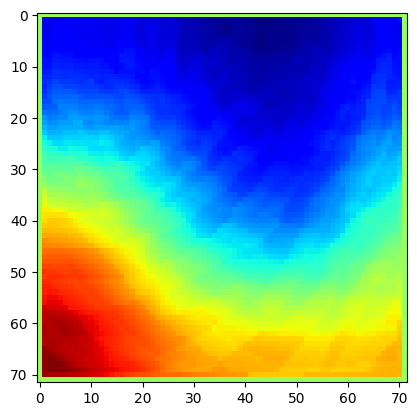

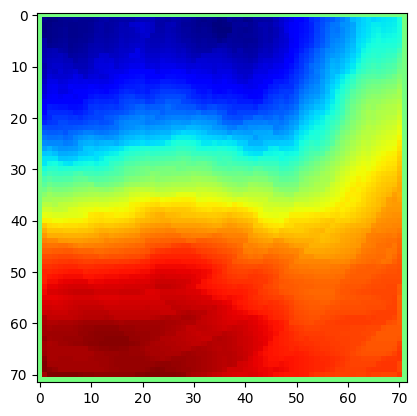

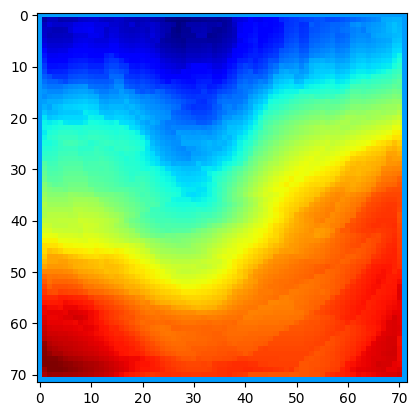

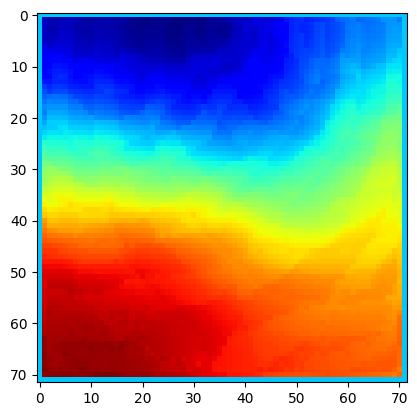

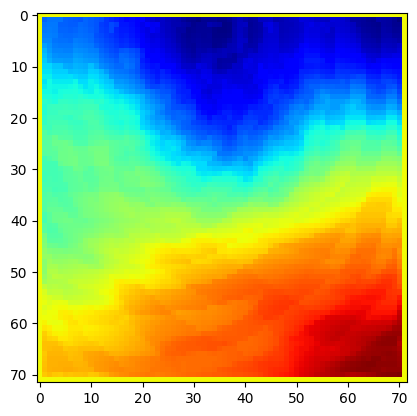

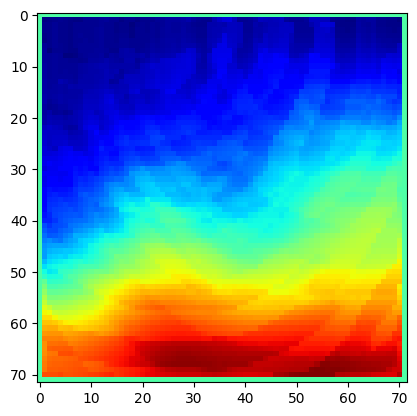

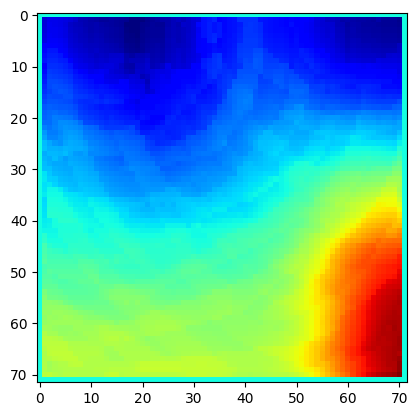

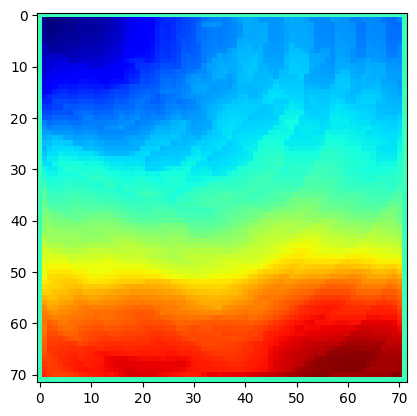

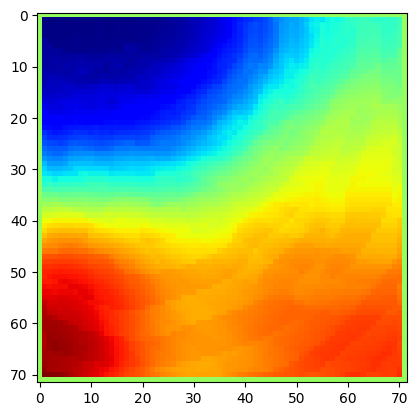

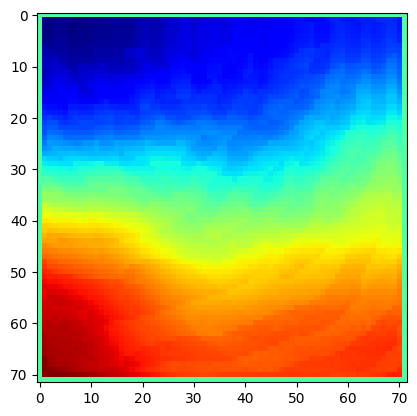